# M17 Eye Diagram

Generate eye diagrams for M17 baseband signals.

This notebook accepts M17 baseband signals.  The baseband must be signed 16-bit,
single channel, 48ksps WAV format.

If you need to convert a raw file to WAV, you can use the following command.

    sox -t s16 -r 48k -c1 input.raw output.wav

Also, `gqrx` will capture baseband audio in wav format.  Those will likely need
to be converte to mono first.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

This is the function for displaying the eye diagram.

This is taken from here: https://notebook.community/daniestevez/jupyter_notebooks/dslwp/paper/Eye%20diagram

In [2]:
def plot_eye(eye, limit, title):
    heatmap = np.vstack([np.histogram(eye[:,j], bins = np.linspace(-2,2,100))[0]/eye.shape[0] for j in np.arange(eye.shape[1])]).T
    
    heatmap_cum = np.zeros_like(heatmap)
    ps = np.concatenate((np.logspace(-3,-1,3), [0.25,0.5,0.75]))
    for p in ps:
        levels = -np.sort(-heatmap, axis = 0)
        a = np.argmax(np.cumsum(levels, axis = 0) >= 1-p, axis = 0)
        cut = levels[a, np.arange(levels.shape[1])]
        heatmap_cum[heatmap >= cut] = p
    
    plt.figure(figsize = (10,6), facecolor = 'w')
    plt.ylim(-limit, limit)
    time = (np.arange(eye.shape[1])-eye.shape[1]//2)/48000.0
    plt.plot(time*1e3, eye[:1000,:].T, color = 'C0', alpha = 0.1)
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (ms)')

def process(data, samples_per_symbol):
    limit = np.max(data)
    extra = len(data) % samples_per_symbol
    if extra != 0:
        data = np.concatenate([data, np.zeros(samples_per_symbol - extra)])
    plot_eye(data.reshape((-1, samples_per_symbol)), limit, "M17 4-FSK Eye Diagram")

Define a function to load the baseband data and apply the RRC filter.

In [3]:
import scipy.io.wavfile
from scipy.signal import lfiltic, lfilter
from commpy.filters import rrcosfilter

def load(filename):
    sample_rate, baseband_data = scipy.io.wavfile.read(filename)
    samples_per_symbol = int(sample_rate / 4800)
    taps = rrcosfilter(int(samples_per_symbol * 15), 0.5, 1.0, 10.0)[1][1:]
    delay = len(taps) // 2
    zl = lfiltic(taps, 1.0, [], [])
    filtered_data, zl = lfilter(taps, 1.0, np.concatenate([baseband_data, np.zeros(delay)]), -1, zl)
    filtered_data *= 0.125
    return filtered_data, samples_per_symbol

Load the data, disply the eye diagram. Manually adjust the eye center by rolling
the data.  Positive values shift to the right. Negative values shift to the left.
There are 10 samples per symbol for a 48ksps input file.

If there is noise at the beginning or end of the sample, it may need to be trimmed
in order to display a clean eye.  This can be done by using array slicing directly
in the notebook (example below).

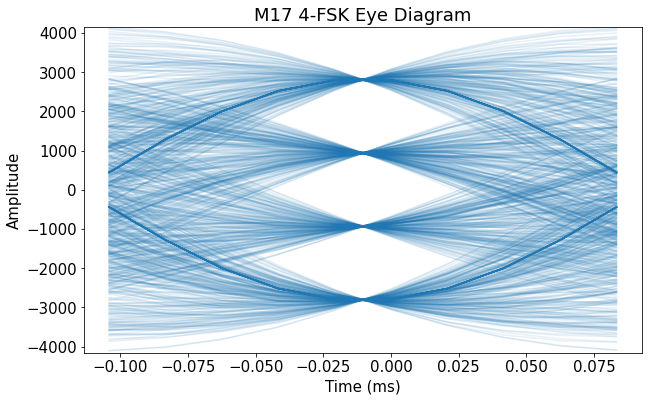

In [4]:
filtered_data, samples_per_symbol = load('m17-4fsk.wav')
filtered_data = np.roll(filtered_data[1000:-1000], 1)  # Manually adjust to center eye
process(filtered_data, samples_per_symbol)